In [1]:
import pickle
with open('cache/df.old.pickle', mode='rb') as h:
    _, df_test = pickle.load(h)
with open('cache/hex.pickle', mode='rb') as h:
    hex_data = pickle.load(h)

In [2]:
import numpy as np
from collections import Counter
labels = df_test['label']
label_counts = np.array(Counter(labels).values())[:, np.newaxis]  # 20 * 1 matrix
id_name = hex_data['id_name']
D = len(id_name)

In [3]:
id_fh = map(lambda x: max(x, key=len), hex_data['id_hierarchical_labels'])  # id_fh for id_full_hierarchy
def get_confusion(Y):
    is_bool = Y.dtype == bool
    cm = np.zeros((20, D), dtype=int)
    if is_bool:
        for i in range(0, len(Y)):
            cm[labels[i], np.nonzero(Y[i])[0]] += 1
    else:
        Y_leaf = np.argmax(Y[:, :20], axis=1)  # most likely leaf predictions
        for i in range(0, len(Y)):
            cm[labels[i], id_fh[Y_leaf[i]]] += 1
    return cm

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
def visualize(cm):
    assert cm.dtype == float
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111)
    heatmap = ax.matshow(cm)
    ax.set_xticks(np.arange(0, D, dtype=int))
    ax.set_xticklabels(id_name, rotation=90)
    ax.set_yticks(np.arange(0, 20, dtype=int))
    ax.set_yticklabels(id_name[:20])
    fig.colorbar(heatmap, shrink=0.5)

In [5]:
state_space = hex_data['state_space']
def to_crf(Y, leaf_weight=4):
    w = np.hstack(([leaf_weight] * 20, [1] * (D - 20)))
    def to_crf_step(y):
        scores = map(lambda s: (w * y)[s].sum(), state_space)
        return state_space[np.argmax(scores)]
    return np.array(map(to_crf_step, Y), dtype=bool)

accuracy=0.459026128266


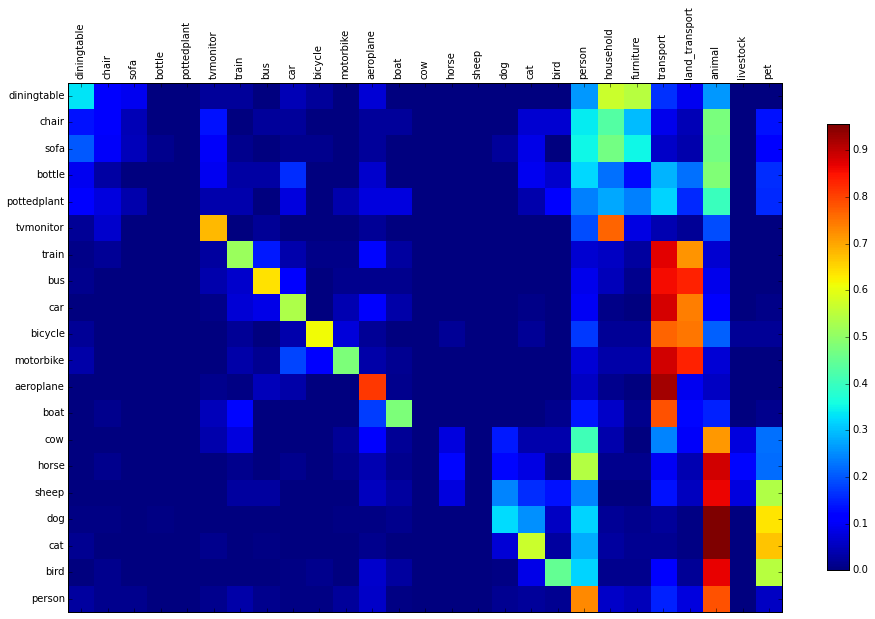

In [6]:
# caffe
Y = np.load('results/test_caffe_4.npy')[3]
cm_raw = get_confusion(Y)
print 'accuracy={}'.format(np.trace(cm_raw, dtype=float) / len(Y))
ncm_raw = cm_raw.astype(float) / label_counts
visualize(ncm_raw)

accuracy=0.468527315914


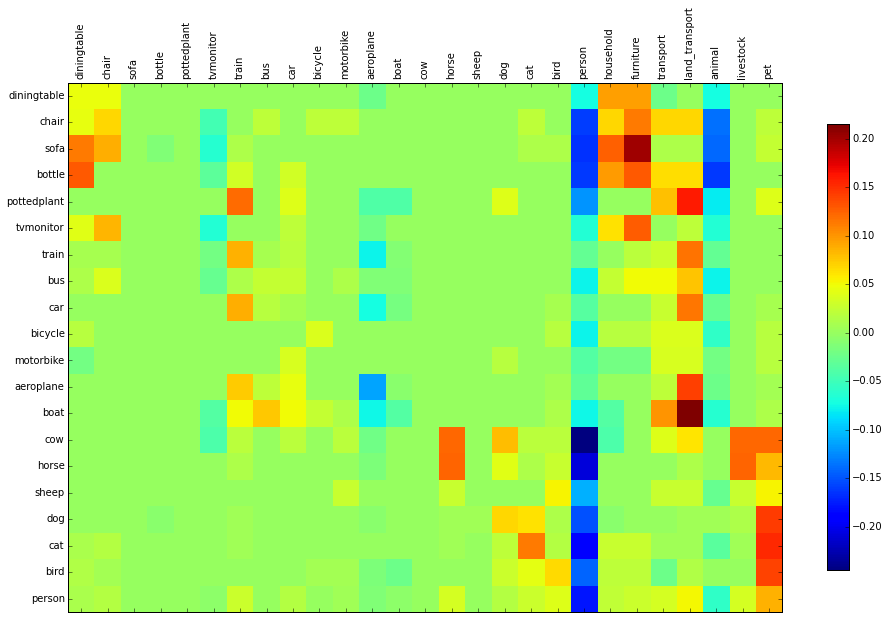

In [7]:
cm_crf = get_confusion(to_crf(Y))
print 'accuracy={}'.format(np.trace(cm_crf, dtype=float) / len(Y))
visualize(cm_crf.astype(float) / label_counts - ncm_raw)

accuracy=0.733966745843


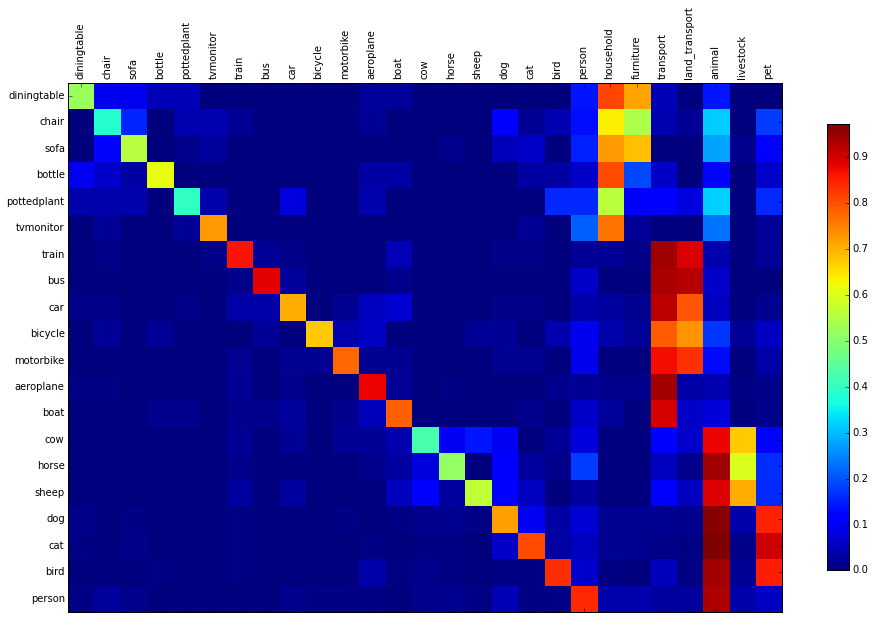

In [8]:
# svm
Y = np.load('results/test_svm_4.npy')[2]
# Y = np.log(Y / (1 - Y))  # log ratio for probability
cm_raw = get_confusion(Y)
print 'accuracy={}'.format(np.trace(cm_raw, dtype=float) / len(Y))
ncm_raw = cm_raw.astype(float) / label_counts
visualize(ncm_raw)

accuracy=0.75


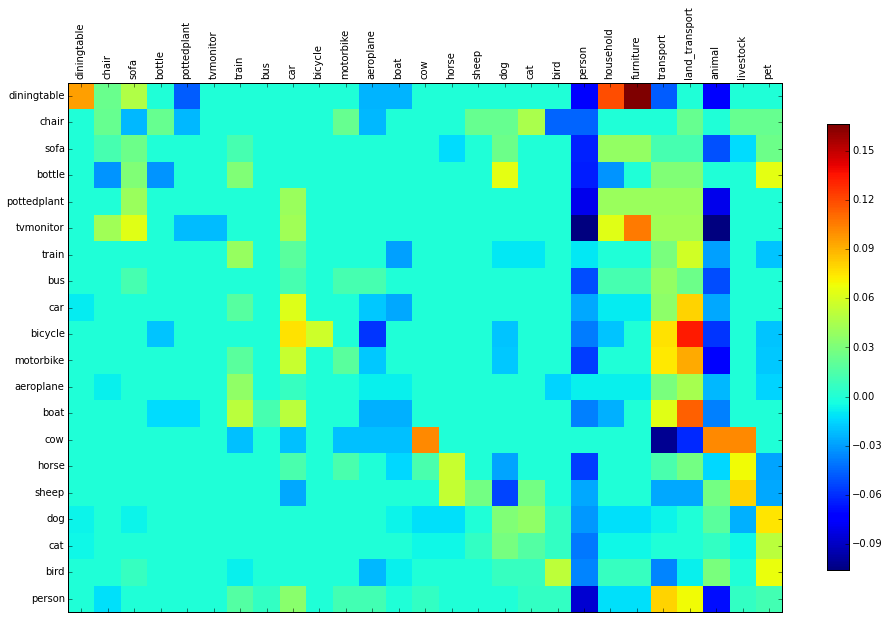

In [9]:
cm_crf = get_confusion(to_crf(Y))
print 'accuracy={}'.format(np.trace(cm_crf, dtype=float) / len(Y))
visualize(cm_crf.astype(float) / label_counts - ncm_raw)